<br>    

<big>

# 1. Decision Trees

---

Decision trees (also referred to as classification and regression trees, CART) are the **traditional** building blocks of data mining and the **classic machine learning algorithm** used extensively in industry and academia since their development in the 1980s. Decision trees do not always deliver the best performance, and represent a trade-off between accuracy and simplicity of explanation.

<img src="images/tree-1.png" width=800 height=600></img>

The Decision Tree algorithm works on the **recursive partitioning approach**

Step 1: We want to find an input variable $X_i$ that can split the dataset into two smaller datasets that are **pure** or **homogeneous** with respect to the dependent variable. In the example above, it means that ideally we want to find the $X_i$ that divides the data into 100% SFO and 100% NYC! (hence, *pure*)

But this is usually not the case, and we end up with something like 70% SFO in one group and 60% NYC in the other.
So we repeat the exercise at the 2 resulting nodes and iterate until the overall maximum *homogeneity* is achieved.

Each test/question at a branch node is formed using an $X_i$ and a $cut-off$. These Variables and Points are picked depending on which combinations result in lowering impurity or increasing information gain.

- All SFO (impurity 0)  
- Half SFO, Half NYC (impurity 1)  
- All NYC (impurity 0) 

At each branch node, we conduct a Greedy Search for the variable-cutoff combination that maximizes gain/minimizes impurity.

## Advantage

Their output is a simple set of if-then rules: they're easy to explain, fast to run and intuitive to understand

## Tree Pruning

- If we allow a tree to grow unrestricted, eventually we will have dozens of nodes and leaves with only 1 data row in them
- This, as you may imagine, is a **highly complex** tree and leads to _overfitting_
- So we optimize for hyperparameters like `max_depth` and `min_samples_leaf`

---

**[Bias Variance Tradeoff Review](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)**

<br>

In [1]:
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('notebook')
sns.set_style('darkgrid')

from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
X = load_digits()['data']
y = load_digits()['target']

X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.85, random_state=112358)

## Build the full tree

In [3]:
tree_1 = DecisionTreeClassifier()

In [4]:
tree_1.fit(X_tr, y_tr)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [7]:
cross_val_score(estimator=tree_1, X=X_tr, y=y_tr, cv=10, scoring='accuracy').mean()

np.float64(0.8526616787065702)

In [8]:
cross_val_score(estimator=tree_1, X=X_te, y=y_te, cv=10, scoring='accuracy').mean()

np.float64(0.7333333333333334)

In [9]:
(pd.Series(cross_val_score(estimator=tree_1, X=X_te, y=y_te, cv=10, scoring='accuracy'))
 .describe()
 .loc[['mean', 'std']]
 .round(3)
 .rename("Full Tree")
 .map(lambda i: f"{i:.1%}")
 .to_frame()
)

,Full Tree
mean,73.3%
std,10.0%


<br>

<big>

**What do you observe?**

- How is the accuracy? What does this mean in terms of Bias?
- How is the standard deviation? What does this mean in terms of variance?
- Comment about the complexity of this model
- If the complexity is too high, what might this mean - and what is a remedy for it?

<br>

<br>


## Visualize the Tree
---

- create a dot file using the `graphviz` library
- create a png file from the dot file

In [10]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("./images/dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)
    try:
        command = ["dot", "-Tpng", "./images/dt.dot", "-o", "./images/dt.png"]
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [11]:
visualize_tree(tree=tree_1, 
               feature_names=['Feature_' + str(x) for x in range(X_tr.shape[1])])

<img src="./images/dt.png"></img>

## Feature Importance

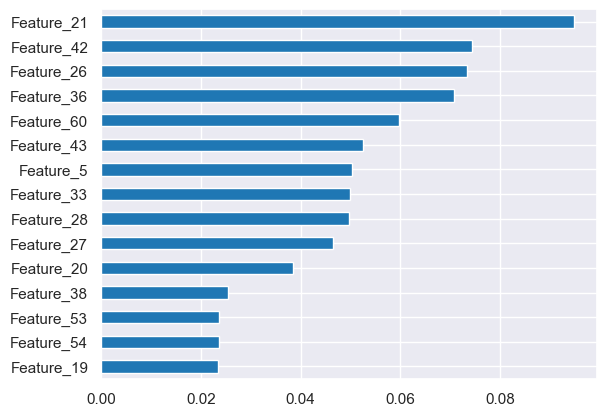

In [10]:
(pd.Series(data=tree_1.feature_importances_, index=[f"Feature_{i}" for i in range(64)])
 .sort_values()
 .tail(15)
 .plot
 .barh()
);


## Build a Tree with GridSearch
---

In [12]:
tree_grid = {
    'max_depth': [12, 24, 32, 40, 48],
    'min_samples_leaf': [20, 30, 50, 100]
}

In [13]:
gscv_tree = GridSearchCV(estimator=DecisionTreeClassifier(), 
                         param_grid=tree_grid, 
                         verbose=True,
                         cv=5,
                         n_jobs=-1)

In [14]:
gscv_tree.fit(X_tr, y_tr)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,DecisionTreeClassifier()
,param_grid,"{'max_depth': [12, 24, ...], 'min_samples_leaf': [20, 30, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [15]:
gscv_tree.best_params_

{'max_depth': 12, 'min_samples_leaf': 20}

In [16]:
(pd.DataFrame(gscv_tree.cv_results_)
    .set_index('params')
    .loc[:, 'mean_test_score':]
 .assign(mean_test_score=lambda fr: [f"{i:.2%}" for i in fr['mean_test_score']])
 .assign(std_test_score=lambda fr: [f"{i:.2%}" for i in fr['std_test_score']])
 .sort_values('rank_test_score')
)

,mean_test_score,std_test_score,rank_test_score
params,,,
"{'max_depth': 12, 'min_samples_leaf': 20}",77.08%,2.45%,1
"{'max_depth': 48, 'min_samples_leaf': 20}",77.08%,2.45%,1
"{'max_depth': 24, 'min_samples_leaf': 20}",77.08%,2.45%,1
"{'max_depth': 40, 'min_samples_leaf': 20}",77.08%,2.45%,1
"{'max_depth': 32, 'min_samples_leaf': 20}",77.08%,2.45%,1
"{'max_depth': 48, 'min_samples_leaf': 30}",73.67%,2.77%,6
"{'max_depth': 40, 'min_samples_leaf': 30}",73.67%,2.77%,6
"{'max_depth': 32, 'min_samples_leaf': 30}",73.67%,2.77%,6
"{'max_depth': 24, 'min_samples_leaf': 30}",73.67%,2.77%,6


## Bonus: Feature Importance

<Axes: >

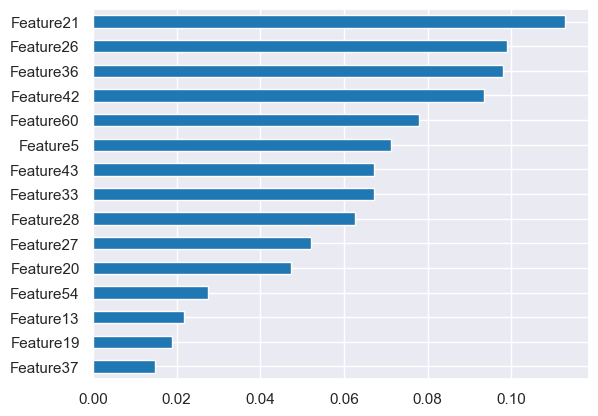

In [17]:
pd.Series(data=gscv_tree.best_estimator_.feature_importances_, 
          index=[f"Feature{i}" for i in range(X_tr.shape[1])]).sort_values().tail(15).plot.barh()

---

<big>

- Decision Trees are a 
    - LOW BIAS (not prone to underfitting), 
    - HIGH VARIANCE (prone to overfitting) algorithm

<br>

- ENSEMBLES are a variance reduction technique

<br>

- In theory, ENSEMBLES OF DECISION TREES create LOW BIAS, LOW VARIANCE models

<br>

---


<br>

<big>

# Model $Ensembles$

## What is ensembling?

**Ensemble learning (or "ensembling")** is the process of combining several predictive models in order to produce a combined model that is more accurate than any individual model.

- **Regression:** take the average of the predictions
- **Classification:** take a vote and use the most common prediction, or take the average of the predicted probabilities

For ensembling to work well, the models must have the following characteristics:

- **Accurate:** they outperform the null model
- **Independent:** their predictions are generated using different processes

**The big idea:** If you have a collection of individually imperfect (and independent) models, the "one-off" mistakes made by each model are probably not going to be made by the rest of the models, and thus the mistakes will be discarded when averaging the models.

There are two basic **methods for ensembling:**

- Manually ensemble your individual models
- Use a model that ensembles for you


> Ensemble methods combine multiple classifiers (using _model averaging_ or _voting_) which may differ in algorithms, input features, or input samples. Statistical analyses showed that ensemble methods yield better classification performances and are also less prone to overfitting. Different methods, e.g., bagging or boosting, are used to construct the final classification decision based on weighted votes.

<br>

## $Bagging$

The primary weakness of **decision trees** is that they don't tend to have the best predictive accuracy. This is partially due to **high variance**, meaning that different splits in the training data can lead to very different trees.

**Bagging** is a general purpose procedure for reducing the variance of a machine learning method, but is particularly useful for decision trees. Bagging is short for **bootstrap aggregation**, meaning the aggregation of bootstrap samples.

What is a **bootstrap sample**? A random sample with replacement:

**How does bagging work (for decision trees)?**

1. Grow B trees using B bootstrap samples from the training data.
2. Train each tree on its bootstrap sample and make predictions.
3. Combine the predictions:
    - Average the predictions for **regression trees**
    - Take a vote for **classification trees**

Notes:

- **Each bootstrap sample** should be the same size as the original training set.
- **B** should be a large enough value that the error seems to have "stabilized".
- The trees are **grown deep** so that they have low bias/high variance.

Bagging increases predictive accuracy by **reducing the variance**, similar to how cross-validation reduces the variance associated with train/test split (for estimating out-of-sample error) by splitting many times an averaging the results.

In [33]:
from sklearn.datasets import load_iris

X = load_iris()['data']
y = load_iris()['target']

In [34]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.8)

In [35]:
from sklearn.ensemble import BaggingClassifier

bagged_tree = BaggingClassifier(estimator=DecisionTreeClassifier(), 
                                n_estimators=100)

bagged_tree.fit(X_tr, y_tr)

,estimator,DecisionTreeClassifier()
,n_estimators,100
,max_samples,1.0
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,None
,random_state,None
,verbose,0


In [36]:
y_pred = bagged_tree.predict(X_te)

In [37]:
accuracy_score(y_te, y_pred)

0.9666666666666667

In [38]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

X = load_digits()['data']
y = load_digits()['target']

X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.85, random_state=112358)

model_bagging = BaggingClassifier(estimator=SVC(), n_estimators=10, random_state=0)
model_bagging.fit(X_tr, y_tr)

,estimator,SVC()
,n_estimators,10
,max_samples,1.0
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,None
,random_state,0
,verbose,0


In [39]:
y_pred = model_bagging.predict(X_te)

In [40]:
accuracy_score(y_te, y_pred)

0.9925925925925926

In [25]:
cross_val_score(model_bagging, X_te, y_te, scoring='accuracy', cv=5)

array([0.92592593, 1.        , 0.94444444, 0.94444444, 0.96296296])

In [26]:
bagged_tree = BaggingClassifier(estimator=DecisionTreeClassifier(), 
                                n_estimators=100)
bagged_tree.fit(X_tr, y_tr)

,estimator,DecisionTreeClassifier()
,n_estimators,100
,max_samples,1.0
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,None
,random_state,None
,verbose,0


In [27]:
pd.Series([cross_val_score(bagged_tree, X_te, y_te, scoring='accuracy', cv=10).mean() for x in range(10)]).std()

np.float64(0.007847036336825057)

In [29]:
print(f"{0.0086331:.2%}")

0.86%


<br>

<big>

# $Random$ $Forests$
--- 
Random Forests is a **slight variation of bagged trees** that has even better performance:

- Exactly like bagging, we create an ensemble of decision trees using bootstrapped samples of the training set.
- However, when building each tree, each time a split is considered, a **random sample of m features** is chosen as split candidates from the **full set of p features**. The split is only allowed to use **one of those m features**.
    - A new random sample of features is chosen for **every single tree at every single split**.
    - For **classification**, m is typically chosen to be the square root of p.
    - For **regression**, m is typically chosen to be somewhere between p/3 and p.

What's the point?

- Suppose there is **one very strong feature** in the data set. When using bagged trees, most of the trees will use that feature as the top split, resulting in an ensemble of similar trees that are **highly correlated**.
- Averaging highly correlated quantities does not significantly reduce variance (which is the entire goal of bagging).
- By randomly leaving out candidate features from each split, **Random Forests "decorrelates" the trees**, such that the averaging process can reduce the variance of the resulting model.


**Advantages of Random Forests:**

- Performance is competitive with the best supervised learning methods
- Provides a more reliable estimate of feature importance
- Allows you to estimate out-of-sample error without using train/test split or cross-validation

**Disadvantages of Random Forests:**

- Less interpretable
- Slower to train
- Slower to predict

<br>

---

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
rf_grid = {
    'max_depth': [1, 2], # build a forest of stumps
    'n_estimators': [100, 250, 400]
}

In [44]:
rf_gscv = GridSearchCV(
    estimator=RandomForestClassifier(), 
    param_grid=rf_grid, 
    cv=5,
    n_jobs=-1
)

In [45]:
rf_gscv.fit(X_tr, y_tr)

,estimator,RandomForestClassifier()
,param_grid,"{'max_depth': [1, 2], 'n_estimators': [100, 250, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,250


In [46]:
rf_gscv.best_params_

{'max_depth': 2, 'n_estimators': 250}

<Axes: >

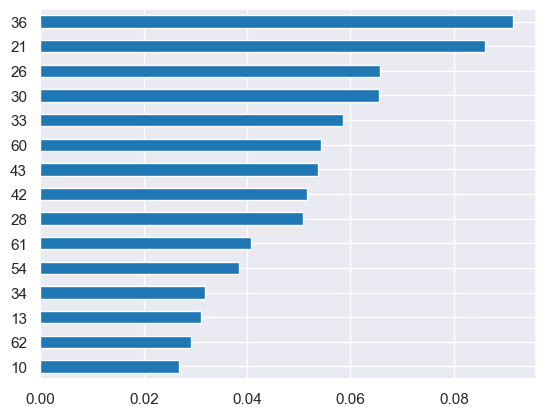

In [47]:
pd.Series(rf_gscv.best_estimator_.feature_importances_).sort_values().tail(15).plot.barh()

In [48]:
pd.Series([cross_val_score(rf_gscv.best_estimator_, X_te, y_te, scoring='accuracy', cv=10).mean() for x in range(10)]).std()

np.float64(0.0102995820319083)

<big>

## $Boosting$

---

- Boosting algorithms **build multiple models** from a dataset by using some other learning algorithm that need not be a particularly good learner (only slightly better than random guessing, like a tree stump)
- Boosting **associates weights with observations** in the dataset and **increases (boosts) the weights for those observations that are hard to model accurately.** 
- A **sequence of models** is constructed, and after each model is constructed the **weights are modified** to give more weight to those observations that are harder to classify. 
- The final model is then an additive model constructed from the sequence of models, each model’s output being weighted by some score.
- There is little tuning required and little is assumed about the learner used, except that it should be a **weak learner!** 
- Note that boosting can fail to perform if there is insufficient data or if the weak models are overly complex. Boosting is also susceptible to noise.
- Boosting algorithms are therefore similar to random forests in that an ensemble of models is built and then combined to deliver a better model

<br>

In [49]:
from sklearn.ensemble import AdaBoostClassifier

In [50]:
grid_ada = {
    'n_estimators': [50, 100],
    'learning_rate': [10**x for x in range(-2, 1)]
}

In [51]:
gscv_ada = GridSearchCV(estimator=AdaBoostClassifier(), 
                        param_grid=grid_ada, 
                        cv=5,
                        n_jobs=-1)

In [52]:
gscv_ada.fit(X_tr, y_tr)

,estimator,AdaBoostClassifier()
,param_grid,"{'learning_rate': [0.01, 0.1, ...], 'n_estimators': [50, 100]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,estimator,None


In [53]:
accuracy_score(y_te, gscv_ada.best_estimator_.predict(X_te))

0.8407407407407408